In [1]:
import spot
spot.setup()
import buddy
from spot.jupyter import display_inline

from decimal import Decimal
import decimal

from consMDP import ConsMDP
from LabeledConsMDP import LCMDP

# Product of lCMDP and DBA with the link to LTL

The goal of this notebook is, given an LTL formula over the set $AP$ of atomic proposition and a consumption MDP with states labeled by subsets of $AP$, decide if there is a strategy for the MDP such that the LTL formula is satisfied with probability 1. We ilustrate the whole concept of a running example in which we want to enforce visiting 2 states infinitely often.

Let's first create a CMDP, we will use the following function for easier definitions of actions using uniform distributions.

In [2]:
def uniform(dests):
    """Create a uniform distribution for given destinations.
    
    dests: iterable of states
    """
    count = len(dests)
    mod = 100 % count
    decimal.getcontext().prec = 2
    prob = Decimal(1)/Decimal(count)
    dist = {i: prob for i in dests}
    last = dests[-1]
    dist[last] = dist[last] + Decimal("0.01")*mod
    return dist

In the following code, we verify that we can achieve the Büchi objective with targets set `{1,2}` with capacity `5` and that is not enough to visit the state `1`. What we actualy want is to visit **both** of these states infinitely often which we solve later.

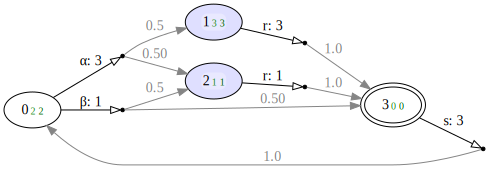

In [3]:
mdp = ConsMDP()
mdp.new_states(4)
mdp.set_reload(3)
mdp.add_action(0, uniform([1,2]), "α", 3)
mdp.add_action(0, uniform([2,3]), "β", 1)
mdp.add_action(1, uniform([3]), "r", 3)
mdp.add_action(2, uniform([3]), "r", 1)
mdp.add_action(3, uniform([0]), "s", 3)
mdp.get_Buchi([1,2], 5, True)
mdp

The corresponding strategy confirms that the state 1 won't be visited by the strategy as there is no occurence of the action `α`.

In [4]:
mdp.energy_levels.get_strategy(4, True)

[{2: 'β'}, {3: 'r'}, {1: 'r'}, {0: 's'}]

## LTL and Büchi automata
Our goal of visiting both states `1` \& `2` infinitely often can be expressed by the LTL formula $\mathsf{G}\mathsf{F} s_1 \land \mathsf{G}\mathsf{F}s_2$ (or in the box-diamond notation: $\Box \diamond s_1 \land \Box \diamond s_2$) where the atomic proposition $s_1$ corresponds to visiting state `1` and the tomic proposition $s_2$ corresponds to visiting state`2`.

This formula can be expressed by a **deterministic** üchi automaton (DBA). We use Spot to make the translation for us. The option `BA` forces Spot to deliver a state-based Büchi automaton (default is transition-based generalized Büchi automaton), the option `deterministic` indicates that we prefer deterministic automata, and `complete` asks for an automaton with complete transition function. If you are not sure that your formula can be translated to a DBA, consult [hierarchy of LTL](https://spot.lrde.epita.fr/hierarchy.html). It is also a good practice to make yourself sure by running 
```python
aut.is_deterministic()
```

In [5]:
f = spot.formula("GF s1 & GF s2")
aut = spot.translate(f, "BA", "deterministic", "complete")

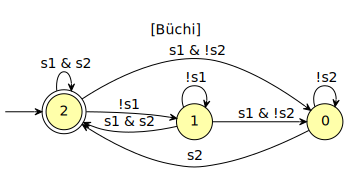

True

In [6]:
display(aut, aut.is_deterministic())

The produced automaton can be used in parallel with our input MDP; this is achieved by a _product_ (alternatively _parallel synchonous composition_) of this automaton an the input MDP. But we need to label states of the MDP with the atomic propositions `s₁` and `s₂`.

## Labeled CMDP
We create a copy of our CMDP and label the states `1` and `2` with the corresponding atomic propositions using the function
```python
LCMDP.state_labels(labels)
```
where `labels` is a list (of length equal to number of states) of sets of ints; the ints are indices to the list `AP` given in the constructor of `LCMDP`.

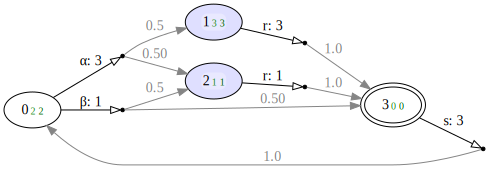

[set(), {0}, {1}, set()]

In [7]:
lmdp = LCMDP(AP=["s1","s2"], mdp=mdp)
lmdp.state_labels = [set(), {0}, {1}, set()]
display(lmdp, lmdp.state_labels)

## Product of labeled CMDP and DBA

The states of the product are tuples `(ms,as)` where `ms` stands for a state of the MDP and `as` stands for a states of the automaton. Let's call the set of states of the MDP $S$ and the set of states of the DBA $Q$; further, the labeling function of the labeled MDP is $\lambda \colon S \to 2^{AP}$ and the transition function of the DBA as $\delta \colon Q \times 2^{AP} \to Q$. For each action `α` and each successor `ms'` for this action from state `ms`, the action `α` of `(ms,as)` has an `α` successor (with the same probability) `(ms', as')` where `as'` is equal to $\delta(as, \lambda(ms'))$.

All tuples that contain a reload state of the mdp, are again reloading. All tuples with an accepting state of the automaton will become targets. The following function `product(lmdp, aut)` returns a CMDP that is the product of `lmdp` and `aut` and a list of target states.

#### Treatment of atomic propositions
Labels (sets of atomic propositions) are represented by sets of integers in LCMDP, while they are represented by _binary decission diagrams (BDD)_ in Spot. One BDD can actually represent a set of labels as it in fact represents a boolean function over AP. In our algorithm, we need to evaluate $\delta(as, \lambda(ms'))$, which is, we need to find an edge in the automaton whose label (guard) is satisfied by the label of `ms'`. We do this in 2 steps:
 1. Create a BDD representing exactly the desired label $\lambda(md')$. This is implemented in 
 ```python
 def get_bdd_for_label(label)
 ```
 2. Perform logical and on this BDD and BDD of all outgoing edges of the current state of the automaton. For all but one edge this operation returns false. We choose the one that is not false (is, in fact, equal to $\lambda(ms')$.

In [8]:
def product(lmdp, aut):
    #TODO check for correct type of mdp
    
    result = ConsMDP()
    num_ap = len(lmdp.AP)
    
    # Check the type of automaton and convert it into
    # complete DBA if needed
    if not aut.is_sba() or not spot.is_complete(aut):
        aut = aut.postprocess("BA", "complete")
        
        
    
    # This will store the list of Büchi states
    targets = []
    # This will be our state dictionary
    sdict = {}
    # The list of output states for which we have not yet
    # computed the successors.  Items on this list are triplets
    # of the form `(mdps, auts, p)` where `mdps` is the state
    # number in the mdp, `auts` is the state number in the 
    # automaton, and p is the state number in the output mdp.
    todo = []
    
    # Mapping of AP representation in MDP to repr. in automaton
    ap2bdd_var = {}
    aut_ap = aut.ap()
    for ap_i, ap in enumerate(lmdp.AP):
        if ap in aut_ap:
            ap2bdd_var[ap_i] = aut_ap.index(ap)
        
    # Given label in mdp, return corresponding BDD
    def get_bdd_for_label(mdp_label):
        cond = buddy.bddtrue
        for ap_i in ap2bdd_var.keys():
            if ap_i in mdp_label:
                cond &= buddy.bdd_ithvar(ap2bdd_var[ap_i])
            else:
                cond -= buddy.bdd_ithvar(ap2bdd_var[ap_i])
        return cond
    
    # Transform a pair of state numbers (mdps, auts) into a state
    # number in the output mdp, creating a new state if needed. 
    # Whenever a new state is created, we can add it to todo.
    def dst(mdps, auts):
        pair = (mdps, auts)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state(name=f"{mdps},{auts}",
                                 reload=lmdp.is_reload(mdps))
            sdict[pair] = p
            todo.append((mdps, auts, p))
            if aut.state_is_accepting(auts):
                targets.append(p)
        return p
    
    # Get a successor state in automaton based on label
    def get_successor(aut_state, mdp_label):
        for e in aut.out(aut_state):
            mdp_bdd = get_bdd_for_label(mdp_label)
            if mdp_bdd & e.cond != buddy.bddfalse:
                return e.dst
    
    # Initialization
    # For each state of mdp add a new initial state
    aut_i = aut.get_init_state_number()
    for mdp_s in range(lmdp.num_states):
        label = lmdp.state_labels[mdp_s]
        aut_s = get_successor(aut_i, label)
        dst(mdp_s, aut_s)

    # Build all states and edges in the product
    while todo:
        msrc, asrc, osrc = todo.pop()
        for a in lmdp.actions_for_state(msrc):
            # build new distribution
            odist = {}
            for mdst, prob in a.distr.items():
                adst = get_successor(asrc, lmdp.state_labels[mdst])
                odst = dst(mdst, adst)
                odist[odst] = prob
            result.add_action(osrc, odist, a.label, a.cons)
            
    return result, targets

In [9]:
p, T = product(lmdp, aut)
p.get_Buchi(T, 5, True)
display_inline(p)

We can now see the result of the product on the labeled MDP and the automaton for $\mathsf{G}\mathsf{F}s_1 \land \mathsf{G}\mathsf{F} s_2$. We can also see that capacity 5 is no longer sufficient for the Büchi objective (the green ∞ indicate that no initial load is sufficient from given state to satisfy the Büchi objectives with targets `T`). In fact, we need at least 9 units of energy to pass the path through mdp-state `1`.

In [10]:
p.get_Buchi(T, 9)
display_inline(p)